# LeNet modeling on COVID-EX-QU dataset
In this notebook, we'll developp a preliminary model to CXR image recognition using the dataset from Kaggle (https://www.kaggle.com/datasets/anasmohammedtahir/covidqu)

- Data will first be analyzed and prepare for modeling.
- The LeNet model will be tuned (using KERAS tuner) to optimize its performance.
- The optimized model (known to be the "best" model) will then be trained of train set and validated on val set.
- The model will then be evaluated on the test set.

In [ ]:
import numpy as np
import pandas as pd
import cv2

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow import keras
from keras_tuner import HyperModel, RandomSearch, HyperParameters
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

## 1- Settings and data readings

In [2]:
# This cells is made to set the different directories used in this notebook
groups = ['COVID-19', 'Normal', 'Non-COVID']
sets = ['Val', 'Test', 'Train']
# Define base pat
base_path = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data'
destination_path = '/kaggle/working/COVID-EX-Qu-dataset'

In [4]:
def normalize_image(x):
    """ Normalize images by dividing pixel values by 255.0 """
    return x / 255.0
train_data_generator = ImageDataGenerator(preprocessing_function = normalize_image)
val_data_generator = ImageDataGenerator(preprocessing_function = normalize_image)
test_data_generator = ImageDataGenerator(preprocessing_function = normalize_image)

In [ ]:
# Run this cell only once to save images data in working directory (+ select persitance of files in Session options)
import shutil

for sett in sets:
  for group in groups:
    ima_dir = os.path.join(drive_base_path, sett, group)
    for dos in os.listdir(ima_dir):
        if dos=="images":
            shutil.copytree(os.path.join(ima_dir, dos), os.path.join(destination_path, sett, group, dos))

In [5]:
# Checking data integrity after Kaggle input to output directory
n_covid = 0
n_noncovid = 0
n_normal = 0
#----Reference number from COVID-EX-qu Kaggle------------
ref_covid = 11956
ref_noncovid = 11263
ref_normal = 10701
#-------------------------------------------------------
for sett in sets:
  for group in groups:
    ima_dir = os.path.join(destination_path, sett, group)
    for dos in os.listdir(ima_dir):
      num = len(os.listdir(os.path.join(ima_dir, dos)))
      print(f"In the set {sett}, there are {num} {dos} of {group}")
      if group =="COVID-19" and dos=='images':
        n_covid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Non-COVID" and dos=='images':
        n_noncovid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Normal" and dos=='images':
        n_normal += len(os.listdir(os.path.join(ima_dir, dos)))

print(f"\nThere are {n_covid} COVID images found in the Drive, {n_covid/ref_covid *100}% of the original dataset from Kaggle.")
print(f"There are {n_noncovid} non-COVID images, {n_noncovid/ref_noncovid *100}% of the original dataset from Kaggle.")
print(f"There are {n_normal} normal images, {n_normal/ref_normal *100}% of the original dataset from Kaggle.")

In the set Val, there are 1903 images of COVID-19
In the set Val, there are 1712 images of Normal
In the set Val, there are 1802 images of Non-COVID
In the set Test, there are 2395 images of COVID-19
In the set Test, there are 2140 images of Normal
In the set Test, there are 2253 images of Non-COVID
In the set Train, there are 7658 images of COVID-19
In the set Train, there are 6849 images of Normal
In the set Train, there are 7208 images of Non-COVID

There are 11956 COVID images found in the Drive, 100.0% of the original dataset from Kaggle.
There are 11263 non-COVID images, 100.0% of the original dataset from Kaggle.
There are 10701 normal images, 100.0% of the original dataset from Kaggle.


## 2- DATA preparation

In [130]:
# Preparation of the data set using image generator
batch_size = 32
train_generator = train_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Train'),
                                                           class_mode="sparse",
                                                           target_size=(256, 256),
                                                           batch_size=batch_size,
                                                           color_mode='grayscale')

val_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Val'),
                                                         class_mode="sparse",
                                                         target_size=(256, 256),
                                                         batch_size=batch_size,
                                                         color_mode='grayscale')

test_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Test'),
                                                          class_mode="sparse",
                                                          target_size=(256, 256),
                                                          batch_size=batch_size,
                                                          color_mode='grayscale', shuffle=False)
        # shuffle=False argument is very important for model evaluation 
        #(I spend many hours trying to figure it out)

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


## 3- KERAS tuner settings

In [24]:
# Model architecture definition

def build_model(hp):
    inputs = Input(shape=(256, 256, 1), name="Input")
    
    # First conv layer
    hp_filters1 = hp.Int('filters_1', min_value=16, max_value=64, step=16)
    conv_1 = Conv2D(filters=hp_filters1, kernel_size=(5, 5), padding='valid', activation='relu')(inputs)
    max_pool_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
    
    # Second conv layer
    hp_filters2 = hp.Int('filters_2', min_value=16, max_value=64, step=16)
    conv_2 = Conv2D(filters=hp_filters2, kernel_size=(3, 3), padding='valid', activation='relu')(max_pool_1)
    max_pool_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)

    flatten = Flatten()(max_pool_2)
    
    # Dropout
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    dropout = Dropout(rate=hp_dropout_rate)(flatten)

    # Dense layer
    hp_units = hp.Int('units', min_value=64, max_value=256, step=64)
    dense_1 = Dense(units=hp_units, activation='relu')(dropout)
    outputs = Dense(units=3, activation='softmax')(dense_1)

    model = Model(inputs=inputs, outputs=outputs)
    
    # Define the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Compile the model with the selected optimizer and learning rate
    optimizer = Adam(learning_rate=hp_learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model


In [27]:
# Tuner preparation
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='/kaggle/working/COVID-EX-Qu-dataset',
    project_name='LeNet_tuning'
)

tuner.search_space_summary()

Search space summary
Default search space size: 5
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
filters_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
# Checking if GPU is activated
import tensorflow as tf
tf.config.list_physical_devices('GPU')

In [28]:
# Tuner parameters searching
# I recommand to activate GPU (took 1h15 with GPU)
tuner.search(train_generator,
             epochs=10,  
             validation_data=val_generator)  

Trial 10 Complete [00h 07m 18s]
val_accuracy: 0.3513014614582062

Best val_accuracy So Far: 0.8578549027442932
Total elapsed time: 01h 16m 13s


In [32]:
# Retrieve and read tuned parameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of filters in the first conv layer is {best_hps.get('filters_1')}.
The optimal number of filters in the second conv layer is {best_hps.get('filters_2')}.
The optimal dropout rate is {best_hps.get('dropout_rate')}.
The optimal number of units in the dense layer is {best_hps.get('units')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it
best_Lenet_model = tuner.get_best_models(num_models=1)[0]


The optimal number of filters in the first conv layer is 32.
The optimal number of filters in the second conv layer is 32.
The optimal dropout rate is 0.5.
The optimal number of units in the dense layer is 256.
The optimal learning rate is 0.0001.



/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


## 4- "Best" model training

In [33]:
# Trained the "best" model
training_history_best_model = best_Lenet_model.fit(
    train_generator,                 
    validation_data=val_generator,             
    epochs=16,                        
    batch_size=200                    
)

Epoch 1/16
679/679 ━━━━━━━━━━━━━━━━━━━━ 48s 66ms/step - accuracy: 0.9146 - loss: 0.2264 - val_accuracy: 0.8638 - val_loss: 0.3697
Epoch 2/16
679/679 ━━━━━━━━━━━━━━━━━━━━ 43s 62ms/step - accuracy: 0.9279 - loss: 0.1947 - val_accuracy: 0.8556 - val_loss: 0.3842
Epoch 3/16
679/679 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.9420 - loss: 0.1633 - val_accuracy: 0.8619 - val_loss: 0.3704
Epoch 4/16
679/679 ━━━━━━━━━━━━━━━━━━━━ 43s 63ms/step - accuracy: 0.9468 - loss: 0.1482 - val_accuracy: 0.8523 - val_loss: 0.4074
Epoch 5/16
679/679 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.9560 - loss: 0.1292 - val_accuracy: 0.8654 - val_loss: 0.3870
Epoch 6/16
679/679 ━━━━━━━━━━━━━━━━━━━━ 43s 63ms/step - accuracy: 0.9633 - loss: 0.1106 - val_accuracy: 0.8619 - val_loss: 0.4089
Epoch 7/16
679/679 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.9662 - loss: 0.1028 - val_accuracy: 0.8643 - val_loss: 0.4210
Epoch 8/16
679/679 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.9729 - loss: 0.0833 - 

In [8]:
# Model saving for future use (in case you stop the notebook)
from keras.models import load_model
best_Lenet_model.save("/kaggle/working/COVID-EX-Qu-dataset.h5")

NameError: name 'best_Lenet_model' is not defined

## Results of training with the "best" model:

In [37]:
train_accuracy = training_history_best_model.history['accuracy']
val_accuracy = training_history_best_model.history['val_accuracy']

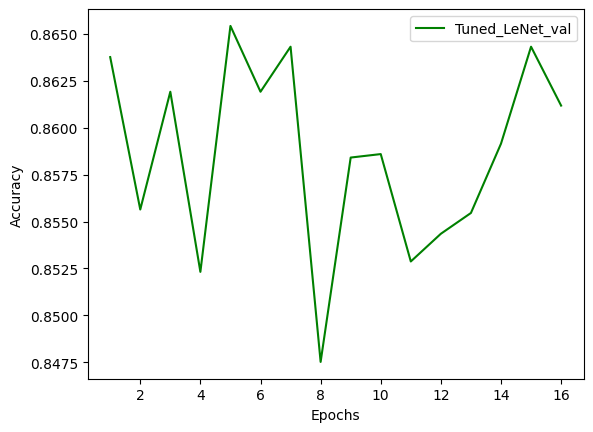

In [46]:
# Results
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(np.arange(1 , 17, 1),
         val_accuracy, 
         label = 'Tuned_LeNet_val',
         color = 'green')
        

plt.legend()

## 5- Model evaluation

In [35]:
# If notebook was stopped or closed, re-load model
from keras.models import load_model
loaded_model = loaded_model("/kaggle/working/COVID-EX-Qu-dataset.h5")

ValueError: Inputs to a layer should be tensors. Got '/kaggle/working/COVID-EX-Qu-dataset.h5' (of type <class 'str'>) as input for layer 'functional_1'.

In [10]:
# Model evaluation on test set
evaluation = loaded_model.evaluate(test_generator)

# Print the evaluation metrics
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


213/213 ━━━━━━━━━━━━━━━━━━━━ 96s 449ms/step - accuracy: 0.8764 - loss: 0.4606
Test Loss: 0.4686085879802704
Test Accuracy: 0.8799352049827576


In [134]:
unique_values, counts = np.unique(predictions, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")


Value: 0, Count: 2247
Value: 1, Count: 2242
Value: 2, Count: 2299


## 6- RESULTS

213/213 ━━━━━━━━━━━━━━━━━━━━ 96s 452ms/step


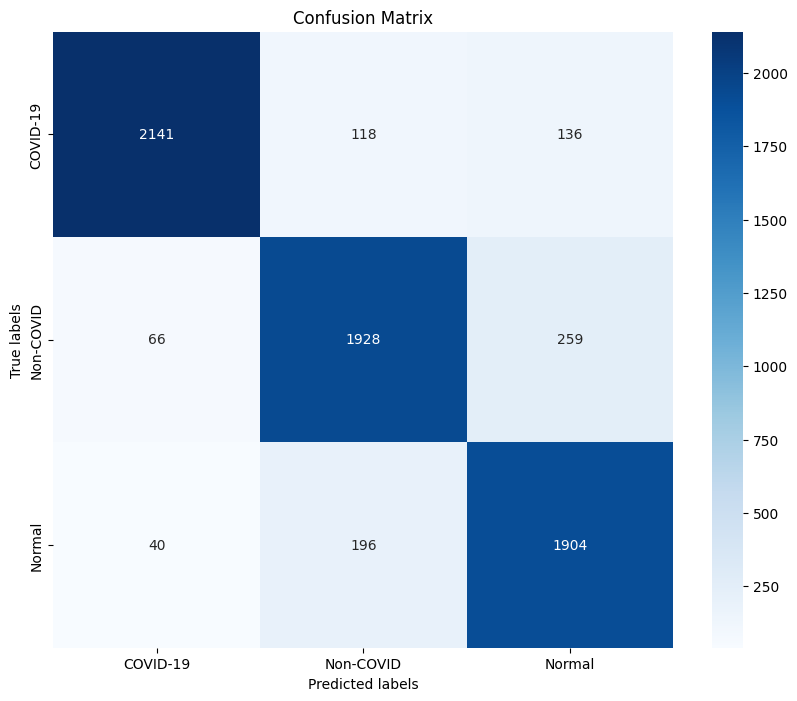

In [135]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions on the test data
predictions = loaded_model.predict(test_generator)
# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)
# Get the true classes
true_classes = test_generator.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
